In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hourly=pd.read_csv('SeattleBike-master/FremontHourly.csv',
                   index_col='Date',parse_dates=True)
hourly.columns=['northbound','southbound']
hourly['total']=hourly['northbound']+hourly['southbound']

In [3]:
daily=hourly.resample('d').sum()
weekly=daily.resample('w').sum()

Text(0, 0.5, 'Weekly riders')

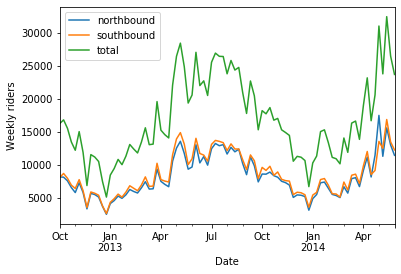

In [4]:
weekly[['northbound','southbound','total']].plot()
plt.ylabel('Weekly riders')

In [5]:
import datetime as dt
def hours_of_daylight(date,axis=23.44,latitude=47.61):
    diff=date-dt.datetime(2000,12,21)
    day=diff.total_seconds()/24./3600
    day%=365.25
    m=1.-np.tan(np.radians(latitude))*np.tan(np.radians(axis)
                                             *np.cos(day*np.pi/182.625))
    m=max(0,min(m,2))
    return 24.*np.degrees(np.arccos(1-m))/180

weekly['daylight']=list(map(hours_of_daylight,weekly.index))
daily['daylight']=list(map(hours_of_daylight,daily.index))

In [6]:
days=['Mon','Tues','Wed',"Thurs",'Fri','Sat','Sun']
daily['dayofweek']=daily['total'].index.dayofweek

In [7]:
for i in range(7):
    daily[days[i]]=(daily.index.dayofweek==i).astype(float)

In [8]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal=USFederalHolidayCalendar()
holidays=cal.holidays('2012','2015',return_name=True)

In [9]:
#holidays_all=pd.concat([holidays,'Day Before '+holidays.shift(-1,'D'),
#                        'Day After '+holidays.shift(1,'D')])
#holidays_all

In [10]:
daily['holiday']=0
#holidays.index[9]
for i in range(len(holidays.index)):
    if (holidays.index[i] in daily.index ) and (daily.loc[holidays.index[i],'dayofweek']<5):
        daily.loc[holidays.index[i],'holiday']=1
    else:
        continue


In [11]:
# load the weather data
weather=pd.read_csv('SeattleBike-master/SeaTacWeather.csv',
                    index_col='DATE',parse_dates=True,usecols=[2,3,6,7])

In [11]:
weather

,PRCP,TMAX,TMIN
DATE,,,
2012-10-01,0,233,89
2012-10-02,0,178,100
2012-10-03,0,189,78
2012-10-04,0,189,83
2012-10-05,0,217,89
...,...,...,...
2014-05-28,0,189,100
2014-05-29,0,189,111
2014-05-30,0,206,89


In [12]:
# temperatures are in 1/10 deg C; convert to F
weather['TMIN']=0.18*weather['TMIN']+32
weather['TMAX']=0.18*weather['TMAX']+32

# precip is in 1/10 mm; convert to inches
weather['PRCP']/=254

In [13]:
# join the weather data to our daily data
daily=daily.join(weather)

In [14]:
daily['daycount']=np.arange(len(daily))

columns=days+['daycount','daylight','TMIN','TMAX','PRCP','holiday']
X=daily[columns]
y=daily['total']

In [15]:
from sklearn.linear_model import LinearRegression
linear_model=LinearRegression().fit(X,y)
daily['final_trend']=linear_model.predict(X)

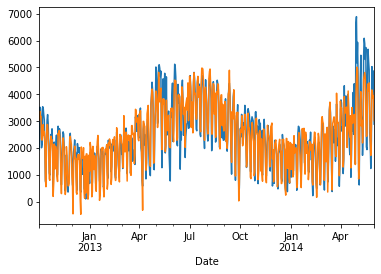

In [17]:
daily['total'].plot()
daily['final_trend'].plot()

In [18]:
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor(200).fit(X,y)
daily['forest_trend']=forest.predict(X)

In [26]:
daily['forest_corrected']=daily['total']-daily['forest_trend']+daily['forest_trend'].mean()

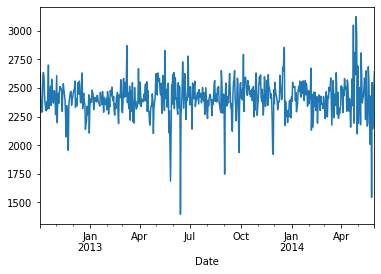

In [28]:
daily['forest_corrected'].plot()

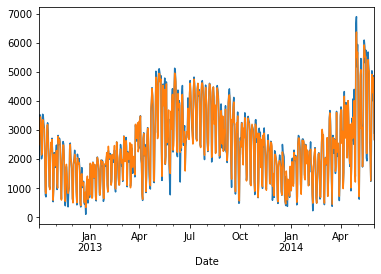

In [19]:
daily['total'].plot()
daily['forest_trend'].plot()

In [48]:
from sklearn.svm import LinearSVR
svm_model = LinearSVR(C=300,max_iter=10000).fit(X,y)
daily['svm_trend']=svm_model.predict(X)

/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [50]:
daily['svm_corrected']=daily['total']-daily['svm_trend']+daily['svm_trend'].mean()

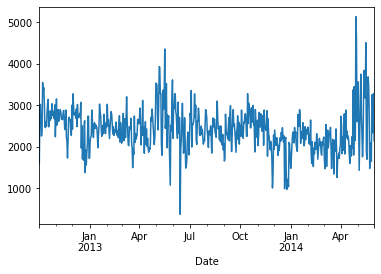

In [51]:
daily['svm_corrected'].plot()

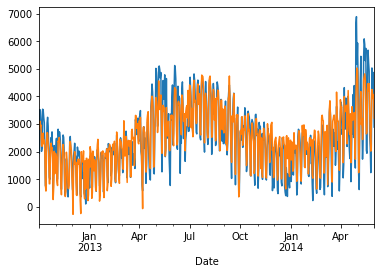

In [49]:
daily['total'].plot()
daily['svm_trend'].plot()

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

linear_param={'fit_intercept':[True,False],'normalize':[True,False]}
grid=GridSearchCV(LinearRegression(),linear_param,cv=3)

In [25]:
grid.fit(X,y)

GridSearchCV(cv=3, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
grid.best_params_

{'fit_intercept': False, 'normalize': True}

In [27]:
linear_model_best=grid.best_estimator_
daily['linear_trend']=linear_model_best.predict(X)

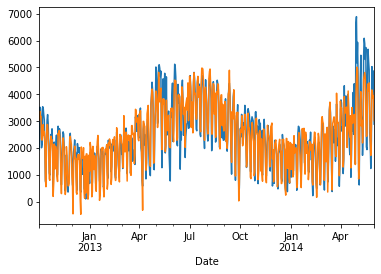

In [28]:
daily['total'].plot()
daily['linear_trend'].plot()

479.87124746426724

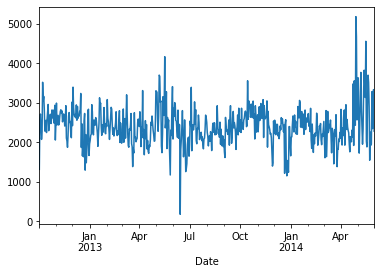

In [29]:
daily['linear_corrected']=daily['total']-daily['linear_trend']+daily['linear_trend'].mean()
daily['linear_corrected'].plot()
np.std(daily['linear_corrected'])

In [35]:
from sklearn.ensemble import RandomForestRegressor

forest_param={'n_estimators':[100,200,300,400,500]}
forest_grid=GridSearchCV(RandomForestRegressor(),forest_param,cv=3)

In [36]:
forest_grid.fit(X,y)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [37]:
forest_grid.best_params_

{'n_estimators': 200}

In [39]:
forest_model_best=forest_grid.best_estimator_
daily['forest_trend']=forest_model_best.predict(X)

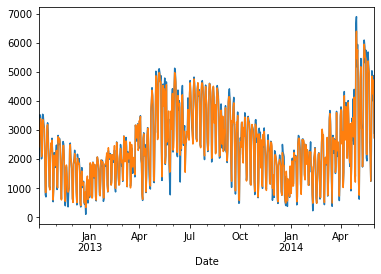

In [40]:
daily['total'].plot()
daily['forest_trend'].plot()

154.59448178310947

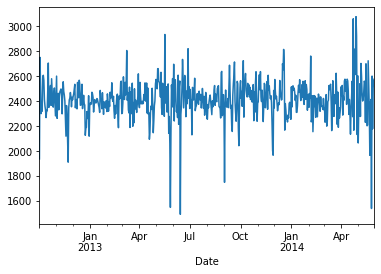

In [41]:
daily['forest_corrected']=daily['total']-daily['forest_trend']+daily['forest_trend'].mean()
daily['forest_corrected'].plot()
np.std(daily['forest_corrected'])

In [46]:
from sklearn.svm import LinearSVR

svm_param = {'C':[10,100,200,300,400,500],'max_iter':[12000,20000,30000,90000]}
svm_grid=GridSearchCV(LinearSVR(),svm_param,cv=3)

In [47]:
svm_grid.fit(X,y)

/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/yw/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                 fit_intercept=True, intercept_scaling=1.0,
                                 loss='epsilon_insensitive', max_iter=1000,
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [10, 100, 200, 300, 400, 500],
                         'max_iter': [12000, 20000, 30000, 90000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [48]:
svm_grid.best_params_

{'C': 400, 'max_iter': 90000}

In [51]:
svm_model_best=svm_grid.best_estimator_
daily['svm_trend']=svm_model_best.predict(X)

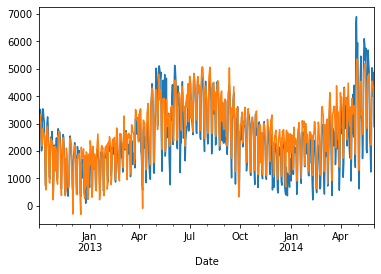

In [53]:
daily['total'].plot()
daily['svm_trend'].plot()

506.0451151865914

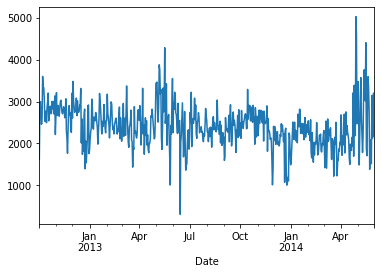

In [54]:
daily['svm_corrected']=daily['total']-daily['svm_trend']+daily['svm_trend'].mean()
daily['svm_corrected'].plot()
np.std(daily['svm_corrected'])